In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
filepath = 'rlData.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-23,182.500000,186.910004,182.179993,186.899994,186.899994,16628100
1,2018-05-24,185.880005,186.800003,185.029999,185.929993,185.929993,12354700
2,2018-05-25,186.020004,186.330002,184.449997,184.919998,184.919998,10965100
3,2018-05-29,184.339996,186.809998,183.710007,185.740005,185.740005,16398900
4,2018-05-30,186.539993,188.000000,185.250000,187.669998,187.669998,13736900


In [2]:
price = data[['Close', 'Low']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price['Low'] = scaler.fit_transform(price['Low'].values.reshape(-1,1))
price

C:\Users\szpzc\AppData\Local\Temp\ipykernel_12324\2826816958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
C:\Users\szpzc\AppData\Local\Temp\ipykernel_12324\2826816958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Low'] = scaler.fit_transform(price['Low'].values.reshape(-1,1))


,Close,Low
0,0.345034,0.296657
1,0.324272,0.359123
2,0.302654,0.346411
3,0.320206,0.330192
4,0.361515,0.363945
...,...,...
247,0.310788,0.342685
248,0.255565,0.278904
249,0.300514,0.334137
250,0.311216,0.328000


In [3]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, 0:1]

    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, 0:1]

    return [x_train, y_train, x_test, y_test]

In [4]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (186, 19, 2)
y_train.shape =  (186, 1)
x_test.shape =  (46, 19, 2)
y_test.shape =  (46, 1)


In [5]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
input_dim = 2
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))



Epoch  0 MSE:  0.2022572159767151
Epoch  1 MSE:  0.17127981781959534
Epoch  2 MSE:  0.12960179150104523
Epoch  3 MSE:  0.06268319487571716
Epoch  4 MSE:  0.04332247003912926
Epoch  5 MSE:  0.07137073576450348
Epoch  6 MSE:  0.0344025157392025
Epoch  7 MSE:  0.02846830151975155
Epoch  8 MSE:  0.03576280176639557
Epoch  9 MSE:  0.04067201539874077
Epoch  10 MSE:  0.03972477465867996
Epoch  11 MSE:  0.03405538573861122
Epoch  12 MSE:  0.02700735442340374
Epoch  13 MSE:  0.022740596905350685
Epoch  14 MSE:  0.023398257791996002
Epoch  15 MSE:  0.026403237134218216
Epoch  16 MSE:  0.027349593117833138
Epoch  17 MSE:  0.025230204686522484
Epoch  18 MSE:  0.02204304188489914
Epoch  19 MSE:  0.01988355629146099
Epoch  20 MSE:  0.019484534859657288
Epoch  21 MSE:  0.020070619881153107
Epoch  22 MSE:  0.02056010626256466
Epoch  23 MSE:  0.02065582387149334
Epoch  24 MSE:  0.020289268344640732
Epoch  25 MSE:  0.019340096041560173
Epoch  26 MSE:  0.018100058659911156
Epoch  27 MSE:  0.017092682421

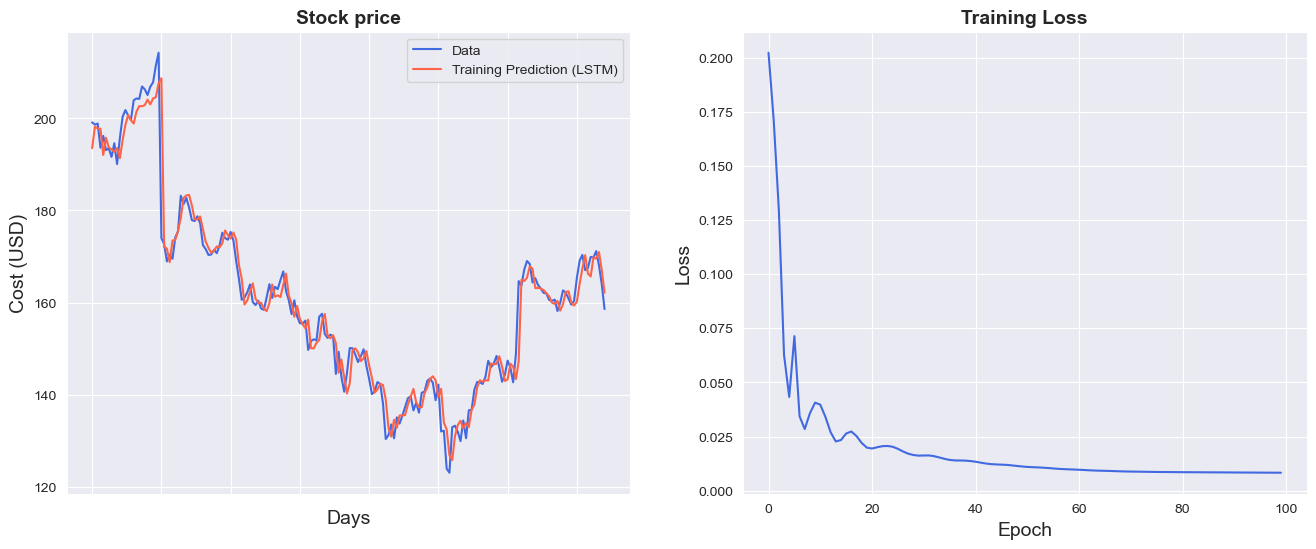

In [9]:
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()